In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch


In [2]:
X_train = np.load("../given_data/X_train.npy")
X_test = np.load("../given_data/X_test.npy")
y_train = np.load("../given_data/y_train.npy")
X_train_resized = np.load("../given_data/X_train_resized.npy")
X_test_resized = np.load("../given_data/X_test_resized.npy")


In [3]:
given_data_resize_flag = 1
if given_data_resize_flag:
    num_img = X_train.shape[0]
    X_train_resized = np.zeros((num_img, 6400))
    for idx_img in range(num_img):
        X_train_1_20x20 = X_train[idx_img:idx_img+1, :].reshape(20, 20)
        X_train_1_80x80 = cv2.resize(X_train_1_20x20, (80, 80))
        X_train_1_resized = X_train_1_80x80.reshape(1, 6400)
        X_train_resized[idx_img, :] = X_train_1_resized
    np.save('../given_data/X_train_resized.npy', X_train_resized)

    num_img = X_test.shape[0]
    X_test_resized = np.zeros((num_img, 6400))
    for idx_img in range(num_img):
        X_test_1_20x20 = X_test[idx_img:idx_img+1, :].reshape(20, 20)
        X_test_1_80x80 = cv2.resize(X_test_1_20x20, (80, 80))
        X_test_1_resized = X_test_1_80x80.reshape(1, 6400)
        X_test_resized[idx_img, :] = X_test_1_resized
    np.save('../given_data/X_test_resized.npy', X_test_resized)


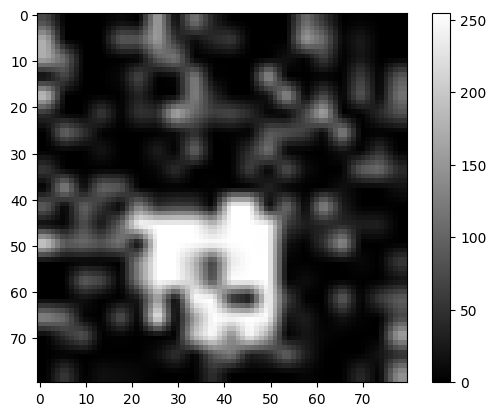

In [4]:
i = 1240
X_train_1_80x801 = X_test_resized[i:i+1, :].reshape(80, 80)
X_train_1_80x802 = X_test[i:i+1, :].reshape(20, 20)
kernel_size = 4
kernel = np.ones((kernel_size, kernel_size), np.uint8)
X_train_1_80x803 = cv2.morphologyEx(X_train_1_80x80, cv2.MORPH_OPEN, kernel, iterations=1)

#X_train_1_80x80 = cv2.resize(X_train_1_20x20, (80, 80))
plt.imshow(X_train_1_80x801, cmap="gray")
plt.colorbar()
plt.show()


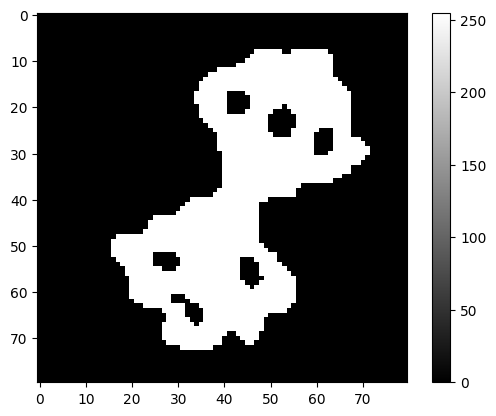

(4768, 1632)

In [5]:
i = 3
X_train_r = X_test_resized[i:i+1, :].reshape(80, 80)
X_train_r_uint8 = (X_train_r).astype(np.uint8)  # 0-1 の浮動小数点数を 0-255 の整数に変換
ret, th = cv2.threshold(X_train_r_uint8, 0, 255, cv2.THRESH_OTSU)
plt.imshow(th, cmap="gray")
plt.colorbar()
plt.show()
num_zeros = np.count_nonzero(th == 0) # 黒
num_255s = np.count_nonzero(th == 255) # 白

num_zeros, num_255s


1240


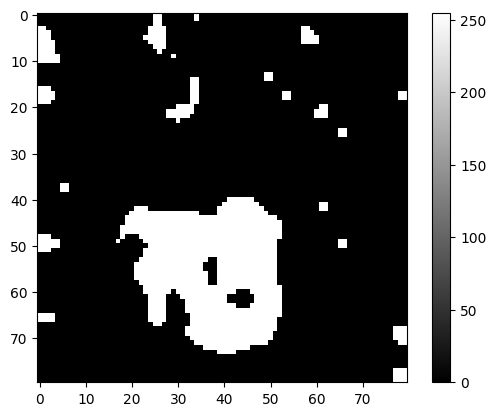

7781


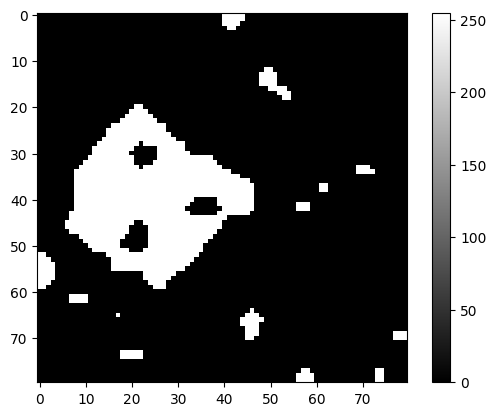

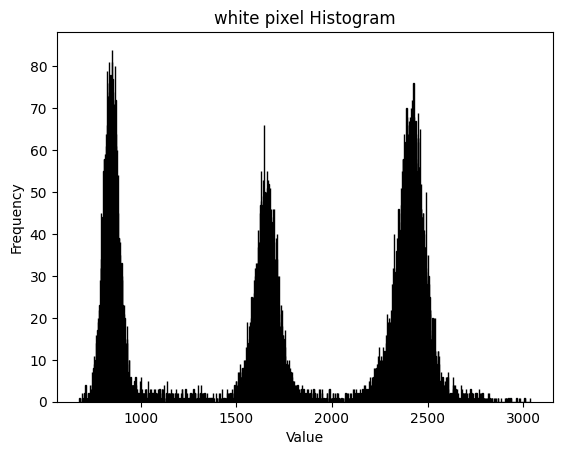

In [6]:
white_pixel_value = []
num_img = X_test_resized.shape[0]
for idx_img in range(num_img):
    X_train_r = X_test_resized[idx_img:idx_img+1, :].reshape(80, 80)
    X_train_r_uint8 = (X_train_r).astype(np.uint8)  # 0-1 の浮動小数点数を 0-255 の整数に変換
    ret, th = cv2.threshold(X_train_r_uint8, 0, 255, cv2.THRESH_OTSU)
    num_255s = np.count_nonzero(th == 255) # 白
    white_pixel_value.append(num_255s)
    if num_255s == 1000:
        print(idx_img)
        plt.imshow(th, cmap="gray")
        plt.colorbar()
        plt.show()
        #break
        

plt.hist(white_pixel_value, bins=range(min(white_pixel_value), max(white_pixel_value) + 2), edgecolor='black')
plt.title('white pixel Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [7]:
def find_squares(img):
    squares = []
    gray = img.copy()
    _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        cnt_len = cv2.arcLength(cnt, True)
        cnt = cv2.approxPolyDP(cnt, 0.02 * cnt_len, True)
        if len(cnt) == 4 and cv2.contourArea(cnt) > 1000 and cv2.isContourConvex(cnt):
            cnt = cnt.reshape(-1, 2)
            max_cos = np.max([angle_cos( cnt[i], cnt[(i + 1) % 4], cnt[(i + 2) % 4] ) for i in range(4)])
            if max_cos < 0.1:
                squares.append(cnt)
    return squares

def angle_cos(p0, p1, p2):
    d1, d2 = (p0 - p1).astype('float'), (p2 - p1).astype('float')
    return abs(np.dot(d1, d2) / np.sqrt(np.dot(d1, d1) * np.dot(d2, d2)))

i = 2
img = X_test_resized[i:i+1, :].reshape(80, 80).astype(np.uint8)
squares = find_squares(img)

# 検出された各正方形に対して処理を実行
for sq in squares:
    cv2.polylines(img, [sq], True, (0, 255, 0), 3)

cv2.imshow('Squares', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
